In [1]:
import numpy as np
import seaborn as sbn
import random
import nengo
import nengo_loihi
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pickle
import _init_paths

from poc_utils import (get_groups_of_poisson_distributed_isi, plot_distplot, plot_sctrplot, plot_barplot,
                       configure_ensemble_for_2x2_max_join_op, get_avam_net_for_2x2_max_pooling,
                      get_groups_of_isi_from_given_isi_dist)
from utils.results_analysis_utils.analyse_results import get_isi_distribution

# Set Constants

In [2]:
NUM_ISI_GROUPS = 256
NUM_NEURONS = NUM_ISI_GROUPS*4
SIZE = 1024
POISSON_ISI_GROUPS = None
FONTSIZE=18
NUM_IMGS=1000

# Spike Generator and Net Creator Utils

In [3]:
def spikes_gen(t):
  ret = np.zeros(NUM_NEURONS)
  for i in range(NUM_ISI_GROUPS):
    for j in range(4):
      if POISSON_ISI_GROUPS[i][j] != 0:
        ret[i*4+j] = 1.0 if int(t*1000)%POISSON_ISI_GROUPS[i][j] == 0 else 0 # Spike at each ISI.
      else:
        ret[i*4+j] = 0 # Since the ISI is 0 => no spikes at any timestep.

  return ret

def get_mjop_net(scale):
  with nengo.Network() as mjop_net:
    inpt = nengo.Node(output=spikes_gen)
    ens = nengo.Ensemble(
        n_neurons=NUM_NEURONS, dimensions=1, gain=1000*np.ones(NUM_NEURONS),
        bias=np.zeros(NUM_NEURONS), seed=0,
        neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
            amplitude=scale/1000, initial_state={"voltage": np.zeros(NUM_NEURONS)}
        )
    )
    # Feed spikes directly instead of synapsing it.
    nengo.Connection(inpt, ens.neurons, synapse=None)
    ens_n_probe = nengo.Probe( # 3rd index neuron is soma after configuring MJOP NET.
        ens.neurons[[i for i in range(NUM_NEURONS) if i%4==3]], synapse=0.01)
  
  return mjop_net, ens, ens_n_probe

def tmax_otpt(t, x):
  ret = np.zeros(NUM_ISI_GROUPS)
  for i in range(NUM_ISI_GROUPS):
    ret[i] = max(x[i*4 : i*4+4]) # Do a max over groups of 4 inputs.
  
  return ret

def get_true_max_net():
  with nengo.Network() as tmax_net:
    inpt = nengo.Node(output=spikes_gen)
    otpt = nengo.Node(output=tmax_otpt, size_in=NUM_NEURONS)
    nengo.Connection(inpt, otpt, synapse=0.01)
    otpt_probe = nengo.Probe(otpt, synapse=None) # Do not synapse, as max is already computed over synapsed inputs.

  return tmax_net, otpt_probe

def get_avam_net(radius):
  with nengo.Network() as avam_net:
    inpt = nengo.Node(output=spikes_gen)
    otpt = nengo.Node(size_in=NUM_ISI_GROUPS)
    
    for i in range(NUM_ISI_GROUPS):
      avam_subnet = get_avam_net_for_2x2_max_pooling(radius=radius)
      nengo.Connection(inpt[i*4 : i*4+4], avam_subnet.input, synapse=0.005)
      nengo.Connection(avam_subnet.output, otpt[i], synapse=None)
    
    otpt_probe = nengo.Probe(otpt, synapse=None)
      
  return avam_net, otpt_probe

def get_avg_net(radius=0):
  with nengo.Network() as avg_net:
    inpt = nengo.Node(output=spikes_gen)
    otpt = nengo.Node(size_in=NUM_ISI_GROUPS)
    
    for i in range(NUM_ISI_GROUPS):
      avg_subnet = get_avam_net_for_2x2_max_pooling(radius=radius, do_max=False)
      nengo.Connection(inpt[i*4 : i*4+4], avg_subnet.input, synapse=0.005)
      nengo.Connection(avg_subnet.output, otpt[i], synapse=None)
    
    otpt_probe = nengo.Probe(otpt, synapse=None)
      
  return avg_net, otpt_probe

# #################################################################
# #################################################################

# Get the Poisson ISI groups

## Poisson Distribution with `mu=2`

In [4]:
# # Get samples of ISI (in groups of 4) from a Poisson Distribution
# poisson_isi_groups_mu_2, isi_poisson_mu_2 = get_groups_of_poisson_distributed_isi(
#     mu=2, size=SIZE, num_groups=NUM_ISI_GROUPS)
# print("Number of ISI Groups (each with size 4): %s" % len(poisson_isi_groups_mu_2))
# plot_distplot(isi_poisson_mu_2, font_size=FONTSIZE, file_name="poisson_isi_mu_2")

## Poisson Distribution with `mu=4`

In [5]:
# # Get samples of ISI (in groups of 4) from a Poisson Distribution
# poisson_isi_groups_mu_4, isi_poisson_mu_4 = get_groups_of_poisson_distributed_isi(
#     mu=4, size=SIZE, num_groups=NUM_ISI_GROUPS)
# print("Number of ISI Groups (each with size 4): %s" % len(poisson_isi_groups_mu_4))
# plot_distplot(isi_poisson_mu_4, font_size=FONTSIZE, file_name="poisson_isi_mu_4")

# Get MNIST Model_1 ISI distribution

Keys:  dict_keys(['conv2d_1.0'])
Number of ISI Groups (each with size 4): 256


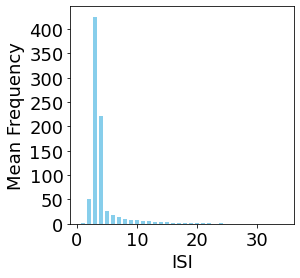

In [6]:
ret_dict = pickle.load(open("mnist_model_1_isi_distribution.p", "rb"))
print("Keys: ", ret_dict.keys())
isi_groups_mnist = get_groups_of_isi_from_given_isi_dist(list(ret_dict["conv2d_1.0"].keys()),
                                                  np.array(list(ret_dict["conv2d_1.0"].values()))/NUM_IMGS,
                                                  256)
print("Number of ISI Groups (each with size 4): %s" % len(isi_groups_mnist))
plot_barplot(list(ret_dict["conv2d_1.0"].keys()), np.array(list(ret_dict["conv2d_1.0"].values()))/NUM_IMGS, 
             font_size=18, file_name="isi_mnist_model_1")

dict_keys(['conv2d_1.0'])
Number of ISI Groups (each with size 4): 256


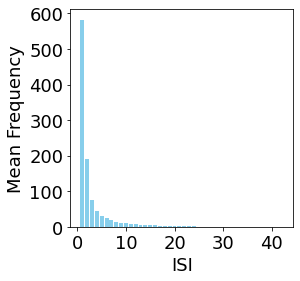

In [7]:
ret_dict = pickle.load(open("cifar10_model_1_isi_distribution.p", "rb"))
print(ret_dict.keys())
isi_groups_cifar10 = get_groups_of_isi_from_given_isi_dist(list(ret_dict["conv2d_1.0"].keys()),
                                                  np.array(list(ret_dict["conv2d_1.0"].values()))/NUM_IMGS,
                                                  256)
print("Number of ISI Groups (each with size 4): %s" % len(isi_groups_cifar10))
plot_barplot(list(ret_dict["conv2d_1.0"].keys()), np.array(list(ret_dict["conv2d_1.0"].values()))/NUM_IMGS, 
             font_size=18, file_name="isi_cifar10_model_1")

# #################################################################
# #################################################################

# Function to be executed to run MJOP Net for different `scale`s.

In [8]:
def run_mjop_and_scatter_plot(scale1, scale2, scale3, file_name):
  # Execute MJOP net on Loihi with `scale1`.
  mjop_net1, ens1, ens1_n_probe = get_mjop_net(scale=scale1)
  with nengo_loihi.Simulator(mjop_net1) as loihi_sim1:
    configure_ensemble_for_2x2_max_join_op(loihi_sim1, ens1)
    loihi_sim1.run(0.1)

  # Execute MJOP net on Loihi with `scale2`.
  mjop_net2, ens2, ens2_n_probe = get_mjop_net(scale=scale2)
  with nengo_loihi.Simulator(mjop_net2) as loihi_sim2:
    configure_ensemble_for_2x2_max_join_op(loihi_sim2, ens2)
    loihi_sim2.run(0.1)

  # Execute MJOP net on Loihi with `scale3`.
  mjop_net3, ens3, ens3_n_probe = get_mjop_net(scale=scale3)
  with nengo_loihi.Simulator(mjop_net3) as loihi_sim3:
    configure_ensemble_for_2x2_max_join_op(loihi_sim3, ens3)
    loihi_sim3.run(0.1)
    
  # Execute the True Max Net.
  tmax_net1, otpt_probe1 = get_true_max_net()
  with nengo.Simulator(tmax_net1) as ngo_sim1:
    ngo_sim1.run(0.1)
    
  # Execute the Avg Net.
  avg_net2, otpt_probe2 = get_avg_net()
  with nengo.Simulator(avg_net2) as ngo_sim2:
    ngo_sim2.run(0.1)
    
  # CONFIRM THE OUTPUT HERE BY SETTING "NUM_ISI_GROUPS=1" and UNCOMMENTING FOLLOWING 3 LINES.
#   plt.figure()
#   plt.plot(loihi_sim1.data[ens1_n_probe])
#   plt.plot(ngo_sim1.data[otpt_probe1])
    
  # Plot the scatter plot.
  x1 = loihi_sim1.data[ens1_n_probe][-10:, :]
  x2 = loihi_sim2.data[ens2_n_probe][-10:, :]
  x3 = loihi_sim3.data[ens3_n_probe][-10:, :]
  x4 = ngo_sim2.data[otpt_probe2][-10:, :]
  y = ngo_sim1.data[otpt_probe1][-10:, :]
  print("Shape of $x_i$, $y$ before taking mean of last 10 timesteps: ", 
        x1.shape, x2.shape, x3.shape, x4.shape, y.shape)
  
  
  x1 = np.mean(x1, axis=0)
  x2 = np.mean(x2, axis=0)
  x3 = np.mean(x3, axis=0)
  x4 = np.mean(x4, axis=0)
  y = np.mean(y, axis=0)
  print("Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps: ", 
        x1.shape, x2.shape, x3.shape, x4.shape, y.shape)
  
  #return x1, x2, x3, x4, y
  plot_sctrplot(x1, x2, x3, x4, y, scale1, scale2, scale3, font_size=FONTSIZE, lgnd_str="s", file_name=file_name)

# Scatter Plot for MJOP with `mu=2` and `scale1=1`, `scale2=2`, `scale3=3`

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:42811
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 0.11s
INFO:DRV:      Compiling Embedded snips....Done 0.28s
INFO:DRV:      Compiling MPDS Registers....Done 0.61ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1629348615.5580764/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 1.01ms
INFO:DRV:      Transferring probes.........Done 6.13ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.89s
INFO:DRV:      Executing...................Done 0.18s
INFO:DRV:      Processing timeseries.......Done 0.01s
INFO:DRV:  Executor: 100 timesteps.........Done 2.11s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Shape of $x_i$, $y$ before taking mean of last 10 timesteps:  (10, 256) (10, 256) (10, 256) (10, 256) (10, 256)
Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps:  (256,) (256,) (256,) (256,) (256,)


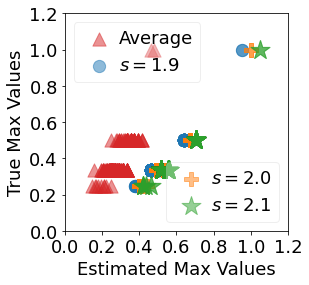

In [9]:
POISSON_ISI_GROUPS = isi_groups_mnist
run_mjop_and_scatter_plot(scale1=1.9, scale2=2.0, scale3=2.1, file_name="mjop_mnist")

# Scatter Plot for MJOP with `mu=4` and `scale1=1`, `scale2=2`, `scale3=3`

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:40305
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Encoding axons/synapses.....Done 0.08s
INFO:DRV:      Compiling Embedded snips....Done 0.33s
INFO:DRV:      Compiling MPDS Registers....Done 0.65ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1629348763.8673801/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 1.08ms
INFO:DRV:      Transferring probes.........Done 5.84ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.91s
INFO:DRV:      Executing...................Done 0.18s
INFO:DRV:      Processing timeseries.......Done 0.01s
INFO:DRV:  Executor: 100 timesteps.........Done 2.14s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Shape of $x_i$, $y$ before taking mean of last 10 timesteps:  (10, 256) (10, 256) (10, 256) (10, 256) (10, 256)
Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps:  (256,) (256,) (256,) (256,) (256,)


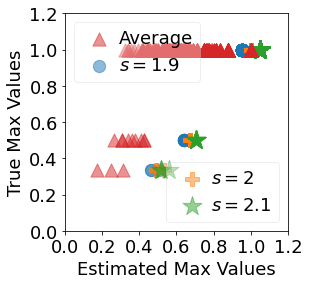

In [10]:
POISSON_ISI_GROUPS = isi_groups_cifar10
run_mjop_and_scatter_plot(scale1=1.9, scale2=2.0, scale3=2.1, file_name="mjop_cifar10")

# #################################################################
# #################################################################

# Function to be executed to run AVAM Net for different radius.

In [15]:
def run_avam_and_scatter_plot(radius1, radius2, radius3, file_name):
  # Execute AVAM Net with radius1.
  avam_net1, otpt_probe1 = get_avam_net(radius=radius1)
  with nengo.Simulator(avam_net1) as ngo_sim1:
    ngo_sim1.run(0.1)
    
  # Execute AVAM Net with radius2.
  avam_net2, otpt_probe2 = get_avam_net(radius=radius2)
  with nengo.Simulator(avam_net2) as ngo_sim2:
    ngo_sim2.run(0.1)
   
  # Execute AVAM Net with radius3.
  avam_net3, otpt_probe3 = get_avam_net(radius=radius3)
  with nengo.Simulator(avam_net3) as ngo_sim3:
    ngo_sim3.run(0.1)
    
  # Execute the True Max Net.
  tmax_net, otpt_probe = get_true_max_net()
  with nengo.Simulator(tmax_net) as ngo_sim:
    ngo_sim.run(0.1)
    
  # Execute the Avg Net.
  avg_net4, otpt_probe4 = get_avg_net()
  with nengo.Simulator(avg_net4) as ngo_sim4:
    ngo_sim4.run(0.1)
    
  # CONFIRM THE OUTPUT HERE BY SETTING "NUM_ISI_GROUPS=1" and UNCOMMENTING FOLLOWING 3 LINES.
#   plt.figure()
#   plt.plot(ngo_sim1.data[otpt_probe1])
#   plt.plot(ngo_sim.data[otpt_probe])
    
  # Plot the scatter plot.
  x1 = ngo_sim1.data[otpt_probe1][-10:, :]
  x2 = ngo_sim2.data[otpt_probe2][-10:, :]
  x3 = ngo_sim3.data[otpt_probe3][-10:, :]
  x4 = ngo_sim4.data[otpt_probe4][-10:, :]
  y = ngo_sim.data[otpt_probe][-10:, :]
  print("Shape of $x_i$, $y$ before taking mean of last 10 timesteps: ", 
        x1.shape, x2.shape, x3.shape, x4.shape, y.shape)
  
  
  x1 = np.mean(x1, axis=0)
  x2 = np.mean(x2, axis=0)
  x3 = np.mean(x3, axis=0)
  x4 = np.mean(x4, axis=0)
  y = np.mean(y, axis=0)
  print("Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps: ", 
        x1.shape, x2.shape, x3.shape, x4.shape, y.shape)
  
  #return x1, x2, x3, y
  plot_sctrplot(x1, x2, x3, x4, y, radius1, radius2, radius3, font_size=FONTSIZE, lgnd_str="r", file_name=file_name)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Shape of $x_i$, $y$ before taking mean of last 10 timesteps:  (10, 256) (10, 256) (10, 256) (10, 256) (10, 256)
Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps:  (256,) (256,) (256,) (256,) (256,)


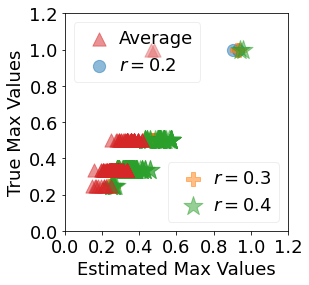

In [16]:
POISSON_ISI_GROUPS = isi_groups_mnist
run_avam_and_scatter_plot(radius1=0.2, radius2=0.3, radius3=0.4, file_name="avam_mnist")

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Shape of $x_i$, $y$ before taking mean of last 10 timesteps:  (10, 256) (10, 256) (10, 256) (10, 256) (10, 256)
Shape of $x_i$, $y_i$ after taking mean of last 10 timesteps:  (256,) (256,) (256,) (256,) (256,)


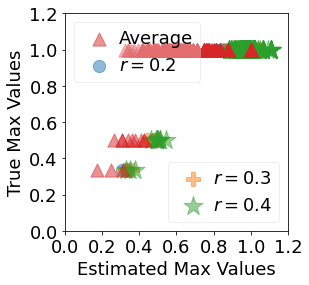

In [17]:
POISSON_ISI_GROUPS = isi_groups_cifar10
run_avam_and_scatter_plot(radius1=0.2, radius2=0.3, radius3=0.4, file_name="avam_cifar10")